# 15.2 Approximate Training

Due to the nature of the softmax operation, since a context word may be anyone in the dictionary $\mathcal{V}$, the computational cost of gradient calculation for the skip-gram model and CBOW is huge.

In order to reduce the computational complextiy, this section will introduce two approximate training methods: negative sampling and hierarchical softmas. Due to the similarity between skip-gram and CBOW model, we will just take the skip-gram model as an example to describe these two approximate training methods.

## 15.2.1 Negative Sampling

Negative sampling modifies the original objective function. Given the context window of a center word $w_c$, the fact that any (context) word $w_o$ comes from this context window is considered as an event with the probability modeled by

$$

P(D=1|w_c, w_o) = \sigma(\mathbf{u_o}^T \mathbf{v}_c)

$$

where $\sigma$ uses the definition of the sigmoid activation function:

$$

\sigma(x) = \cfrac{1}{1 + exp(x)}

$$

I.e., we consider the $w_c, w_o$ pair in calculating softmax only if the similarity between them are high (measured by sigmoid function) ==> Simplified softmax (just considered as binary: either relative or not)

Let's begin by maximizing the joint probability of all such events in text sequences to train word embeddings. Specifically, given a text sequence of length $T$, denote by $w^{(t)}$ the word at time step $t$ and let the context window size by $m$, consider maximizing the joint probability:

$$

\prod_{t=1}^T \prod_{-m \leq j \leq m, j \not = 0} P(D=1 | w^{(t)}, w^{(t + j)})

$$

However, the above formula only considers those events that involve positive examples. As a result, the joint probability is maximized to 1 only if all word vectors are equal to infinity. Of course, such results are meaningless. 

To make the objective function more meaningful, negative sampling adds negative examples sampled from a predefined distribution.

Denote by $S$ the event that a context word $w_o$ comes from the context window of a center word $w_c$. For this event involving $w_o$, from a predeifined distribution $P(w)$ sample $K$ noise words that are not from this context window.

### Cf) Notes on Noise Contrastive Estimation and Negative Sampling [1]

Let us assume the following model of language which predicts a word $w$ in a vocab $V$ based on some given context $c$:

$$

p_\theta (w|c) = \cfrac{u_\theta (w, c)}{\sum_{w' \in V} u_\theta (w', c)} = \cfrac{u_\theta (w, c)}{Z_\theta (c)}

$$

where $u_\theta (w, c) = exp s_\theta (w, c)$ assigns a score to a word in contex, $Z(c)$ is the partition function that normalizes this into a probability distribution. The satandarad learning procedure is to maximize the likelihood of a sample of training data. Unfortunately, computing this probability (and its derivatives) is expensive since this requires summing over all words in $V$, which is generally very large.

Noise contrastive estimation and negative sampling prpesent an evolution. These work by transforming the computationally expensive learning problem into a binary classification proxy problem that uses the same parameters but requires statistics that are easier to compute.



#### Empirical distribution, Noise distributions, and Model distributions.

 - $\tilde{p}(w|c)$, $\tilde{p}(c)$: empirical distributions
 - Goal: to find the parameters $\theta$ of a model $p_\theta (w|c)$ that approximates the empirical distribution as closely as possible, in terms of minimal cross-entropy.
 - To avoid costly summations, a "noise" distribution $q(w)$ is used.

#### Noise Contrastive Estimation (NCE)

NCE reduces the language model estimation problem to the problem of estimating the parameters of a probabilistic binary classificer that uses the same parameters to distinguish samples from the empirical distribution and the samples generated by the noise distribution. The two-class training data is generated as follows:

 - Sample a $c$ from $\tilde{p}(c)$
 - Sample one true sample from $\tilde{p}(w|c)$, with auxiliary label $D = 1$, indicating the datapoint is drawn from the true distribution.
 - Sample $k$ noise samples from $q(w)$, with auxiliary label $D=0$, indicating these datapoints are noise.
 
Thus, given $c$, the joint probability of $(d, w)$ has the form of two distributions:

$$

p(d, w|c) = 

\begin{cases}
    \frac{k}{1+k} \times q(w) \text{ if } d = 0 \\
    \frac{1}{1+k} \times \tilde(p)(w|c) \text{ if } d = 1

\end{cases}

$$

Using the definition of conditional probability, this can be turned into a conditional probability of $d$ having observed $w$ and $c$:

$$

p(d, w|c) = \cfrac{p(d, w, c)}{p(c)} = \cfrac{p(d|w, c)p(w|c)p(c)}{p(c)} = p(d|w, c)p(w|c)

$$

Thus, we obtain the following:

$$

P(D=0|c, w) = \cfrac{k \times q(w)}{\tilde{p}(w|c) + k \times q(w)} \\

P(D=1|c, w) = \cfrac{\tilde{p}(w|c)}{\tilde{p}(w|c) + k \times q(w)}

$$

With the assumption that neural network can self-normalize the output (that is, we don't need to explicitly estimate $z_c = 1$), we obtain the following:


$$

P(D=0|c, w) = \cfrac{k \times q(w)}{u_\theta (w, c) + k \times q(w)} \\

P(D=1|c, w) = \cfrac{u_\theta (w, c) }{u_\theta (w, c)  + k \times q(w)}


$$

We now have a binary classification problem with parameters $\theta$ that can be trained to maximize conditional log-likelihood of a dataset $\mathcal{D}$, with $k$ negative samples chosen:

$$

\mathcal{L}_{NCE_k} = \sum_{(w, c) \in \mathcal{D}} \left[ log p(D=1 | c, w) + k \mathbb{E}_{\bar{w} \sim q} [log p(D=0 | c, \bar{w})]\right]

$$

However, since expectation of the second term is intractable, we perform Monte-Carlo approximation via k-times negative sampling.

$$


\mathcal{L}_{NCE_k}^{MC} = \sum_{(w, c) \in \mathcal{D}} \left[ log p(D=1 | c, w) + \sum_{i=1, \bar{w} \sim q}^k log p(D=0|\bar{w}, c)\right]


$$


### Negative Sampling

Negative sampling is a variation of NCE used by the popular word2vec tool which generates a proxy corpus and also learns $\theta$ as a binary classification problem, but it defines the conditional probabilities given $(w, c)$ differently:

$$

p(D = 0|c, w) = \cfrac{1}{u_\theta (w, c) + 1} \\
p(D = 1|c, w) = \cfrac{u_\theta (w, c)}{u_\theta (w, c) + 1}

$$

This objective can be understood as follows: it equivalent to NCE when $k = |V|$ and $q$ is uniform. As a result, aside from the $k = |V|$ and uniform $q$ case, the conditional probabilities of $D$ given $(w, c)$ are not consistent with the language model probabilities of $(w, c)$ and therefore the $\theta$ estimated using this as an objective will not optimize the likelihood of the language model. Thus, while negative sampling may be appropriate for word representation learning, it does not have the same asymptotic consistency guarantees that NCE has.



[1] Dyer, Chris. "Notes on noise contrastive estimation and negative sampling." arXiv preprint arXiv:1410.8251 (2014).

## 15.2.2 Hierarchical Softmax

As an alternative approximate training method, hierarchical softmax uses the binary tree, a data structure illustrated in the follo, where each leaf node of the tree represents a word in dictionary $\mathcal{V}$.

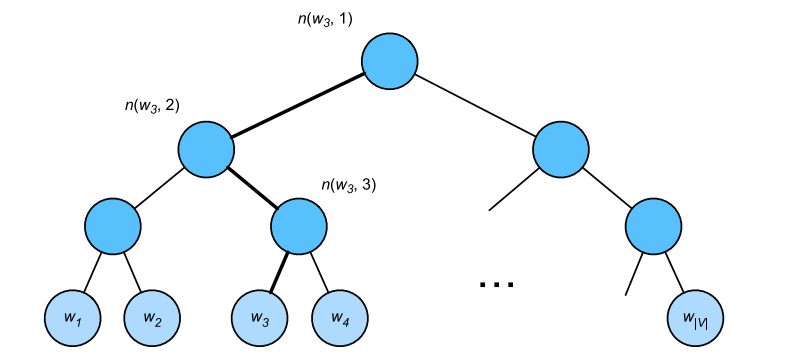

Denote by $L(w)$ the number of nodes (including both ends) on the path from the root node to the leaf node representing word $w$ in the binary tree. Let $n(w, j)$ be the $j^{th}$ node on this path, with its context word vector being $\mathbf{u}_{n(w, j)}$. For example $L(w_3) = 4$ in the abov figure. Hierarchical softmax approximates the conditional probability as:

$$

P(w_o | w_c) = \prod_{j=1}^{L(w_o) - 1} \sigma(\mathbf{I}\left[ n(w_o, j+1) = leftChild(n(w_o, j)) \right] \cdot \mathbf{u}_{n(w_o, j)}^T \mathbf{v}_c)

$$


where $\mathbb{I}$ is an indicator variable which denotes +1 if the event is true, and -1 else.

To illustrate, let's calcualte the conditional probability of generating word $w_3$ given word $w_c$. This requires dot products between the word vector $\mathbf{v}_c$ of $w_c$ and non-leaf node vectors on the path from the root to $w_3$, which is traversed left, right, then left:


$$

P(w_3 | w_c) = \sigma(\mathbf{u_{n(w_3, 1)}^T \mathbf{v_c}})\sigma(-\mathbf{u_{n(w_3, 2)}^T \mathbf{v_c}})\sigma(\mathbf{u_{n(w_3, 3)}^T \mathbf{v_c}})

$$

Fortunately, since $L(w_o) - 1$ is on the order $\mathcal{O}(log_2 |\mathcal{V}|)$ due to the binary tree structure, when the dictionary size $\mathcal{V}$ is huge, the computational cost for each training step using hierarchical softmax is significantly reduced compared with that without approximate training.